***
## Real Estate Price Prediction(Model)
### Created By: Arezoo Tirdad
***

- [3. Model](#model)
    - [3.1 Creating Holdout Cross Validation Set](#model)
    - [3.2 Baseline Model](#baseline_model)
    - [3.3 Trying Different Algorithms](#algo)
    - [3.4 Feature Engineering](#feature_engin)
    - [3.5 Model Tuning](#tuning)

In [1]:
import warnings;
warnings.simplefilter('ignore')

# EDA & plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px #to plot geographical points
import plotly.graph_objects as go #to plot geometry objects
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import plotly.offline as pyo
pyo.init_notebook_mode()
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Modeling
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<a id="model"></a>
# 3. Model
## Feature Selection & Creating a Holdout CV Set

In [141]:
df = pd.read_csv("final_df.csv", index_col=[0])

In [175]:
df.shape

(13651, 49)

In [176]:
# we'll include features(buildingAge, age_binned) & (numOfElementarySchools', 'has_elementary_school') here to make X_train 
# but have to select one for each to run the model
num_features = ['propertyTaxRate', 'in_austin', 'street', 'latest_saleyear', 'latest_salemonth', 'latitude', 'longitude', 
                'numOfSecurityFeatures', 'numOfPatioAndPorchFeatures', 'numOfParkingFeatures', 'parkingSpaces',
                'hasView', 'hasSpa', 'has_accessibility_feature',
                'numOfBedrooms', 'numOfStories', 'numOfBathrooms', 'lotSizeSqFt', 'livingAreaSqFt', 'fsi', 'age_binned', 'buildingAge',
                'numOfMiddleSchools', 'numOfElementarySchools', 'has_elementary_school', 'has_school_walking',
                'avgSchoolSize', 'avgSchoolRating', 'avgSchoolDistance', 'MedianStudentsPerTeacher']

cat_features = ['zipcode']

X = df[num_features + cat_features]
y = df['price']

# splitting test & full training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

print(f'test set:{X_test.shape, y_test.shape}')
print(f'train set:{X_train.shape, y_train.shape}')

test set:((2731, 31), (2731,))
train set:((10920, 31), (10920,))


<a id = "baseline_model"></a>
## Baseline Model
We'll set up two baseline models with RandomForestRegressor and LinearRegression to get a preliminary feature importance.
First defining functions to evaluate models by R2 and RMSE scores and also plotting feature importance charts and residual plot.

#### Observations:
- dropping price outliers, like the legitimate very expensive properties, has the greatest impact on model's performance.
- removing listings that are more than 100 years old and listings with prices past the 98% percentile(instead of 99%) reduces RMSE by roughly 20k although R2 is not improved greatly. 
- Neither StandardScaler or MinMaxScaler change the results in a meaningful way. They'll only prioritize features differently.
- In the initial models, we see model underestimate proprties with prices on the higher end. Given that we handled price and lotsize outliers, there are less luxury houses in the dataset, same thing with properties with very big lots. We'll need to investigate this later.
- We can add new features to better identify and estimate these listings.
- Adding polynomial features for lot size and living area didn't improve the models performance, neither applying log transformation on features or label.
- Tested LabelEncoder on zipcode(instead of TargetEncoder) and didn't improve the model.

In [177]:
# making a pipeline of preprocessing steps applied to individual columns
# scaling doesn't seem to improve the model in any way
preprocessors = ColumnTransformer([
    ('te', TargetEncoder(cols='zipcode', handle_missing='ignore'), ['zipcode']),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False), ['lotSizeSqFt', 'livingAreaSqFt']),
    ('scaler', MinMaxScaler(), ['lotSizeSqFt', 'livingAreaSqFt'])
], remainder='passthrough')

# Random Forest baseline model
baseline_rf = make_pipeline(
    preprocessors,
    RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=5)
)

# Linear Regression baseline model
baseline_lr = make_pipeline(preprocessors, LinearRegression())

# Setting number of cross-validation sets and evaluation metrics
kfold_cv = KFold(5, random_state=42, shuffle=True)
scoring = ['r2', 'neg_root_mean_squared_error']

# Applying Log Transformation to the Target Variable, price
transformed_baseline = TransformedTargetRegressor(
    regressor=baseline_rf,
    func=np.log1p,  # log(1 + x) transformation
    inverse_func=np.expm1  # exp(x) - 1 inverse transformation
)

In [136]:
# function to return test and training scores
def cv_scores(pipe, features):
    """
    Function to return average R2 and RMSE scores across folds.
    """
    scores = cross_validate(pipe, X_train[features], y_train, n_jobs=-1, scoring=scoring, cv=kfold_cv, return_train_score=True)
    
    scores_df = pd.DataFrame({'test_R2': scores['test_r2'].mean(), 
                              'test_R2_std': scores['test_r2'].std(),
                              'test_RMSE': -scores['test_neg_root_mean_squared_error'].mean(),
                              'train_R2': scores['train_r2'].mean(),
                              'train_RMSE': -scores['train_neg_root_mean_squared_error'].mean()},
                              index=[0])
    return scores_df

In [137]:
X_train.columns

Index(['propertyTaxRate', 'in_austin', 'street', 'latest_saleyear',
       'latest_salemonth', 'latitude', 'longitude', 'numOfSecurityFeatures',
       'numOfPatioAndPorchFeatures', 'numOfParkingFeatures', 'parkingSpaces',
       'hasView', 'hasSpa', 'has_accessibility_feature', 'numOfBedrooms',
       'numOfStories', 'numOfBathrooms', 'lotSizeSqFt', 'livingAreaSqFt',
       'fsi', 'age_binned', 'buildingAge', 'numOfMiddleSchools',
       'numOfElementarySchools', 'has_elementary_school', 'has_school_walking',
       'avgSchoolSize', 'avgSchoolRating', 'avgSchoolDistance',
       'MedianStudentsPerTeacher', 'zipcode'],
      dtype='object')

In [178]:
# starting features selection
features = ['propertyTaxRate', 'in_austin',
            'latest_saleyear', 'latest_salemonth', 'latitude', 'longitude', 'zipcode',
            'numOfSecurityFeatures', 'numOfPatioAndPorchFeatures', 'numOfParkingFeatures',
            'has_accessibility_feature', 'hasView', 'hasSpa', 
            'numOfBedrooms', 'numOfBathrooms', 'lotSizeSqFt', 'livingAreaSqFt', 'fsi', 'numOfStories', 'age_binned', 
            'numOfMiddleSchools', 'numOfElementarySchools', 'has_school_walking',
            'avgSchoolSize', 'avgSchoolRating', 'avgSchoolDistance', 'MedianStudentsPerTeacher']

cv_scores(baseline_rf, features=features)

test_R2  test_R2_std  test_RMSE  train_R2  train_RMSE
0     0.79         0.01 117,090.82      0.91   78,668.09

In [179]:
# testing log transformation of label
cv_scores(transformed_baseline, features=features)

test_R2  test_R2_std  test_RMSE  train_R2  train_RMSE
0     0.79         0.01 118,873.39      0.90   79,909.23

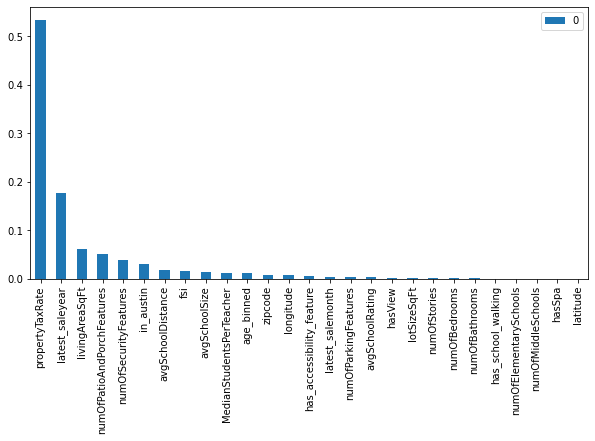

In [180]:
# let's see feature importance on all initial features using randm forest baseline model
baseline_rf.fit(X_train[features], y_train)

importances = baseline_rf.steps[1][1].feature_importances_
pd.DataFrame(importances, index=features).sort_values(by=0, ascending=False).plot(kind='bar', figsize=(10,5));

In [181]:
# linear regression
cv_scores(baseline_lr, features=features)

test_R2  test_R2_std  test_RMSE  train_R2  train_RMSE
0     0.71         0.01 139,471.70      0.71  138,237.84

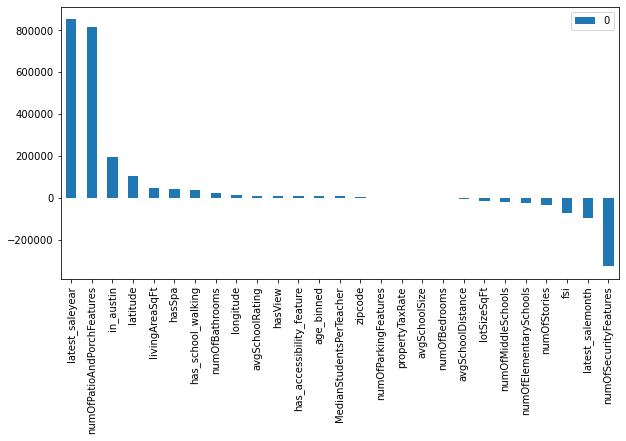

In [182]:
baseline_lr.fit(X_train[features], y_train)
importances = baseline_lr.steps[1][1].coef_
pd.DataFrame(importances, index=features).sort_values(by=0, ascending=False).plot(kind='bar', figsize=(10,5));

So far, some of the featurs we assume to be very important like number of bedrooms, bathroom or lot size have not been picked up by the models. This may be due to the randomness inherent to feature selection in Random Forest. 
From here, we'll iteratively remove features and monitor scores, feature importance charts and residual plot to reduce noise. We'll do this in steps to make sure features removed don't have interaction with other features and that's not impacting model's performance.
We can revisit the removed features after selecting final algorithm and tuning the model.

In [183]:
# A function to evaluate results in feature selection
def plot_feature_importance(model, features):
    """
    Plotting feature importance chart of a pipeline model.
    """
    importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else model.coef_
    # plotting bar chart
    pd.DataFrame(importances, index=X_train[features].columns).sort_values(by=0, ascending=False).plot(kind='bar', figsize=(8,4));
    
# A function to plot residuals and actual vs predicted values
def plot_residuals(y_pred):
    residuals = y_test - y_pred

    # Residuals vs. Actual values plot
    fig, axs = plt.subplots(1,2, figsize=(12,6))

    # Predicted vs Actual plot
    axs[0].scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axs[0].set_xlabel('Actual')
    axs[0].set_ylabel('Predicted')
    axs[0].set_title('Actual vs Predicted')

    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1}, ax=axs[1], )
    axs[1].set_xlabel('Predicted Values')
    axs[1].set_ylabel('Residuals')
    axs[1].set_title('Residuals vs Predicted Values')
    
    plt.tight_layout()
    plt.show() 

In [184]:
# A function to run all 3 defined functions to evaluate each list of features using a certain pipeline
def eval_features(pipe, features):
    print(cv_scores(pipe=pipe, features=features))
    
    # Fit the pipeline model on subset of X_train and get prediction on same features of test set
    pipe.fit(X_train[features], y_train)
    
    model = pipe.regressor.steps[1][1] if hasattr(pipe, 'regressor') else pipe.steps[1][1]
    y_pred = pipe.predict(X_test[features])
    
    plot_residuals(y_pred=y_pred)
    plot_feature_importance(model=model, features=features)

Starting point:
	test_R2	   test_R2_std	   test_RMSE	 train_R2	  train_RMSE
	  0.79	      0.01	        117,777	       0.90	        79,490

Removing features: 
- round #1: numOfElementarySchools, numOfSecurityFeatures
     test_R2    test_R2_std    test_RMSE     train_R2     train_RMSE
      0.79        0.01          117,718       0.90          80,333
      
- round #2: numOfPatioAndPorchFeatures, numOfParkingFeatures, has_accessibility_feature
     test_R2    test_R2_std    test_RMSE      train_R2    train_RMSE
      0.79         0.01         118,032       0.90         81,146
      
- round #3: has_elementary_school, numOfMiddleSchools, has_school_walking, has_view
    test_R2     test_R2_std    test_RMSE     train_R2     train_RMSE
      0.79         0.01         117,976       0.90         81,251
      
- round #4: avgSchoolDistance, has_spa
    test_R2     test_R2_std    test_RMSE     train_R2     train_RMSE
      0.79         0.01         118,206       0.90         81,888
      
- round #5: fsi, in_austin
    test_R2     test_R2_std    test_RMSE     train_R2     train_RMSE
      0.79         0.01         117,931       0.90         82,514

   test_R2  test_R2_std  test_RMSE  train_R2  train_RMSE
0     0.80         0.01 116,741.87      0.90   81,297.93


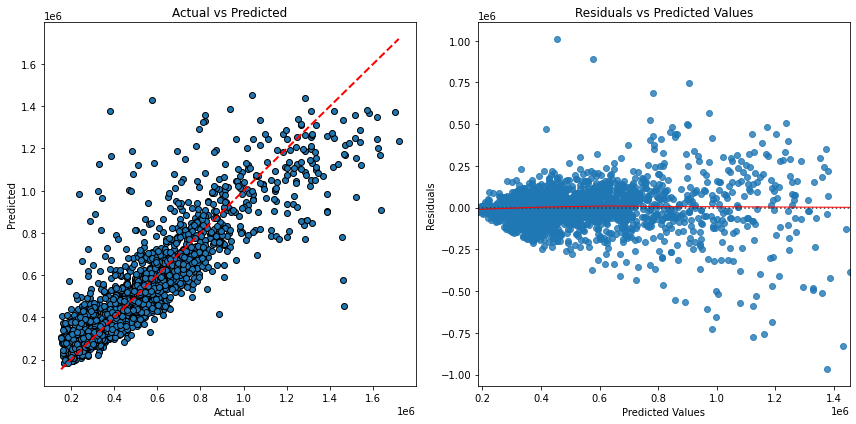

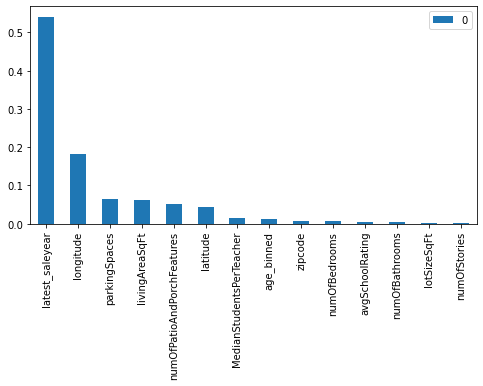

In [185]:
# X_train['log_lotSizeSqFt'] = np.log1p(X_train['lotSizeSqFt'])
# X_train['log_livingAreaSqFt'] = np.log1p(X_train['livingAreaSqFt'])

revised_features = ['latest_saleyear', 'latitude', 'longitude', 'zipcode',
                    'numOfPatioAndPorchFeatures',
                    'parkingSpaces',
                    'numOfBedrooms', 'numOfBathrooms', 'lotSizeSqFt', 'livingAreaSqFt', 'numOfStories', 'age_binned',
                    'avgSchoolRating', 'MedianStudentsPerTeacher']

# cv_scores(baseline_rf, revised_features)
eval_features(pipe=baseline_rf, features=revised_features)

<a id = "algo"></a>
## Trying different algorithms

In [297]:
# a dictionary of different algorithms to try
regressors = {
    "linear Regression": LinearRegression(),
#     "SGD Lasso Regressor": SGDRegressor(random_state=42, penalty='l1', alpha=0.05, learning_rate='adaptive'),
#     "SGD Ridge Regressor": SGDRegressor(random_state=42, penalty='l2', alpha=0.01, learning_rate='adaptive'),
    "knn": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=10),
    "Random Forest": RandomForestRegressor(random_state=42, max_depth=10),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42, max_depth=3),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100, max_depth=3)
}

# a pipeline of all steps with a placeholder to apply individual regressors
pipe = Pipeline([
    ('preprocess', preprocessors),
    ('regressor', None)
])

# Iterate over each algorithm with basic parameters
models_scores = dict()
for name, reg in regressors.items():
    pipe.set_params(regressor=reg)
    scores = cross_val_score(pipe, X_train[revised_features], y_train, scoring='r2', n_jobs=-1, cv=kfold_cv)
    print(f'{name} : {scores.mean():.3f} (+/- {scores.std():.3f})')
    models_scores[name] = scores

linear Regression : 0.692 (+/- 0.006)
knn : 0.701 (+/- 0.010)
Decision Tree : 0.682 (+/- 0.033)
Random Forest : 0.792 (+/- 0.012)
Gradient Boosting Regressor : 0.781 (+/- 0.012)
LightGBM : 0.783 (+/- 0.014)
XGBoost : 0.792 (+/- 0.013)


<a id="feature_engin" ></a>
## Feature Engineering
We can create interaction features between the most important features. For example, the interaction between lotSizeSqFt and livingAreaSqFt(FSI) might provide additional insights into our outliers.

New featers:
- FSI: floor area / lot area
- crime count in each zipcode
- Adding up all features: didn't improve

In [214]:
# testing kmeans as a feature: doesn't improve model's performance
# only trainig score is improved slightly. If decided to keep kmeans, we have to tune number of clusters and random_state
pre_kmeans = ColumnTransformer([
    ('te', TargetEncoder(cols='zipcode', handle_missing='ignore'), ['zipcode']),
    ('scaler', MinMaxScaler(), ['lotSizeSqFt', 'livingAreaSqFt']),
    ('kmeans', KMeans(n_clusters=4, random_state=1), kmeans_features)
], remainder='passthrough')

new_rf = make_pipeline(
    pre_kmeans,
    RandomForestRegressor(random_state=42, n_estimators=300, max_depth=20, min_samples_split=10, min_samples_leaf=5, 
                          criterion='poisson')
)
                 
cv_scores(new_rf, revised_features+['propertyTaxRate'])

test_R2  test_R2_std  test_RMSE  train_R2  train_RMSE
0     0.79         0.01 117,477.24      0.90   80,102.56

In [298]:
df['all_features'] = df.numOfAccessibilityFeatures + df.numOfPatioAndPorchFeatures + df.numOfSecurityFeatures + \
df.numOfWaterfrontFeatures + df.numOfWindowFeatures + df.numOfCommunityFeatures

In [492]:
df.all_features.value_counts()

0     7315
2     1524
1     1399
3     1292
4     1032
5      576
6      323
7      150
8       47
9       12
10       8
11       1
14       1
12       1
19       1
Name: all_features, dtype: int64

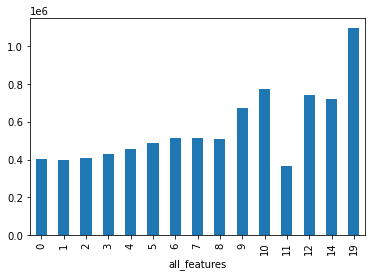

In [493]:
df.groupby('all_features')['price'].median().plot(kind='bar');

In [215]:
crime = pd.read_csv("Crime_Reports.csv", 
                    usecols=['Occurred Date', 'Zip Code'],
                   infer_datetime_format=True, parse_dates=[0])

zipcodes = df['zipcode'].unique()

# making a dataframe of number of crimes in each zipcode up to year 2022
crime_df = crime[(crime['Occurred Date'].dt.year < 2022)].groupby('Zip Code').count().reset_index()\
.rename(columns={'Zip Code':'zipcode', 'Occurred Date': 'crime_cnt'})

crime_df = crime_df[crime_df['zipcode'].isin(zipcodes)].reset_index(drop=True)
crime_df.head()

zipcode  crime_cnt
0 78,617.00      17522
1 78,619.00          1
2 78,652.00        412
3 78,653.00        770
4 78,660.00       8113

In [502]:
df = df.merge(crime_df, how='left', on='zipcode')

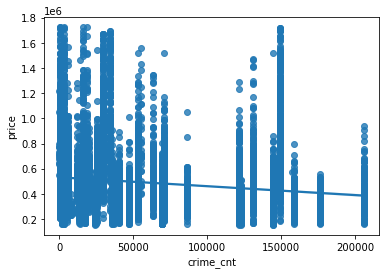

In [504]:
sns.regplot(data=df, x='crime_cnt', y='price');

In [216]:
# adding crime_cnt & recreating train and test sets
X_train = X_train.merge(crime_df, how='left', on='zipcode').set_index(train_indices)
X_test = X_test.merge(crime_df, how='left', on='zipcode').set_index(test_indices)

X_train.head(3)

propertyTaxRate  in_austin            street  latest_saleyear  \
3200             1.98          1   Sterlinghill Dr             2020   
3348             1.98          1         Wooten Dr             2019   
597              1.98          1      Balcones Way             2018   

      latest_salemonth  latitude  longitude  numOfSecurityFeatures  \
3200                 6     30.39     -97.69                      1   
3348                 8     30.36     -97.72                      1   
597                  6     30.44     -97.80                      0   

      numOfPatioAndPorchFeatures  numOfParkingFeatures  ...  \
3200                           2                     2  ...   
3348                           0                     1  ...   
597                            0                     1  ...   

      numOfMiddleSchools  numOfElementarySchools  has_elementary_school  \
3200                   1                       0                      0   
3348                   1                       0                      0   
597                    1                       1                      1   

      has_school_walking  avgSchoolSize  avgSchoolRating  avgSchoolDistance  \
3200                   0           1073             4.00               1.70   
3348                   1           1019             4.00               0.63   
597                    1           1632             9.00               0.83   

      MedianStudentsPerTeacher  zipcode  crime_cnt  
3200                        13    78758     158183  
3348                        14    78757      53382  
597                         16    78750      25262  

[3 rows x 32 columns]

In [217]:
X_train.crime_cnt.isnull().sum()

0

   test_R2  test_R2_std  test_RMSE  train_R2  train_RMSE
0     0.80         0.01 116,440.87      0.90   81,210.32


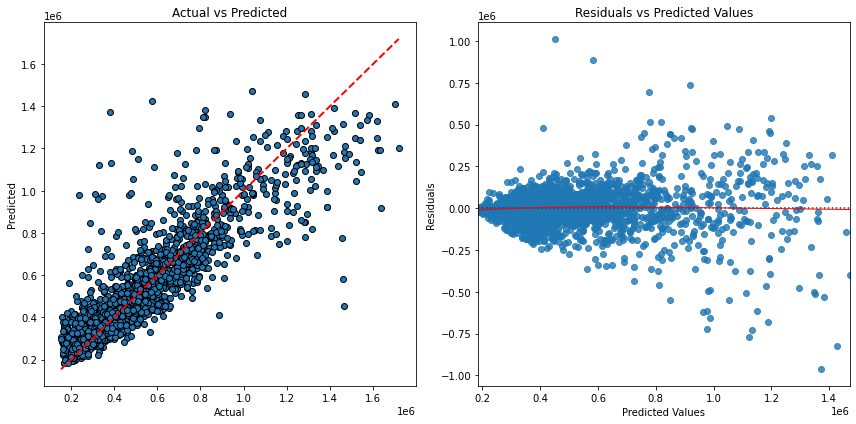

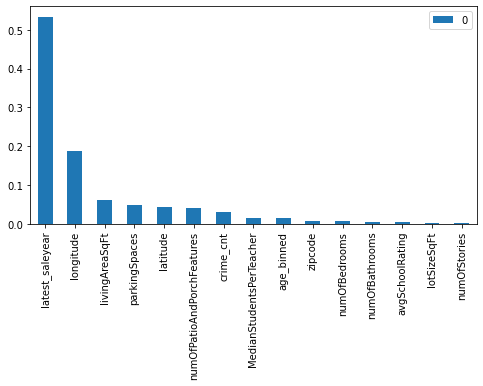

In [218]:
# new feature "all_features" doesn't seem to help
# 'crime_cnt' doesn't improve model significantly(doesn't move training score at all) but it's the 7th important feature
# and improves RMSE of test set slightly
eval_features(baseline_rf, features=(revised_features+['crime_cnt']))

### Adding market analysis data related to each zipcode
Due to lack of information on certain zipcodes, adding these features will require ignoring part of our dataset so after seeing that model will not be improved dramatically by these features, I decided to forgo using them.

In [77]:
market_analysis = pd.read_csv("2014_Housing_Market_Analysis_Data_by_Zip_Code.csv",
                             usecols=[0,1,2,6,8,10,12,13,25,26,27,28,29])
market_analysis = market_analysis[market_analysis['Zip Code'].isin(zipcodes)].rename(columns={'Zip Code':'zipcode'})

In [78]:
print(f"number of zipcodes in market analysis report: {market_analysis.zipcode.nunique()}")
print(f"number of zipcodes in our dataset: {df.zipcode.nunique()}")

number of zipcodes in market analysis report: 36
number of zipcodes in our dataset: 45


In [110]:
# we have to decide how many rows we'll lose if we decide to forgo price prediction on these zipcodes,
# also let's see where they are.
print(f"current size of dataset: {df.shape[0]}")
df2 = df.merge(market_analysis, how='inner')
print(f"size of dataset minus some of the zipcodes: {df2.shape[0]}")

current size of dataset: 13682
size of dataset minus some of the zipcodes: 12183


In [119]:
df2[['price']+list(market_analysis.columns)].corr().style.background_gradient(cmap='coolwarm', axis=None)

KeyError: "['pop_below_poverty', 'median_income', 'unemployment', 'affordability', 'rent_restricted', 'median_rent', 'median_value', 'rent_change', 'value_change', 'trans_cost'] not in index"

In [379]:
# which are the zipcodes we're missing?
missing_zipcodes = set(df.zipcode.unique()).difference(df2.zipcode.unique())
missing_zipcodes

[78660,
 78725,
 78733,
 78734,
 78736,
 78737,
 78738,
 78747,
 78619,
 78652,
 78653,
 78719]

In [396]:
missing_zipcodes_df = zipcodes_austin[zipcodes_austin.zipcode.isin(missing_zipcodes)]
missing_zipcodes_df = gpd.GeoDataFrame(missing_zipcodes_df, geometry=gpd.GeoSeries.from_wkt(missing_zipcodes_df['geometry']))
missing_zipcodes_df.shape

(11, 2)

In [395]:
fig = px.choropleth_mapbox(missing_zipcodes_df, geojson=missing_zipcodes_df.geometry.__geo_interface__,
                           locations=missing_zipcodes_df.index,
                           mapbox_style="carto-positron",
                           center=dict(lat=30.30, lon=-97.74),
                           opacity=0.5, zoom=9, hover_name='zipcode')
    
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [508]:
# do we have null values?
df2.isnull().sum()

city                                                                              0
streetAddress                                                                     0
zipcode                                                                           0
description                                                                       0
latitude                                                                          0
longitude                                                                         0
propertyTaxRate                                                                   0
garageSpaces                                                                      0
hasAssociation                                                                    0
hasCooling                                                                        0
hasGarage                                                                         0
hasHeating                                                                  

In [116]:
# let's rename some of the feature names, we're adding 10 features
market_analysis = market_analysis.drop(columns=['Percentage of homes within 1/4-mi of transit stop', 
                                                'Average monthly transportation cost'])

market_analysis = market_analysis\
.rename(columns={'Population below poverty level':'pop_below_poverty',
                 'Median household income':'median_income',
                 'Unemployment':'unemployment',
                 'Homes affordable to people earning less than $50,000':'affordability',
                 'Rent-restricted units': 'rent_restricted',
                 'Median rent':'median_rent',
                 'Median home value': 'median_value',
                 'Change in median rent, 2000-2012': 'rent_change',
                 'Change in median home value, 2000-2012': 'value_change',
                 'Percentage of housing and transportation costs that is transportation-related': 'trans_cost'
                 })

In [129]:
print('new train set: ', X_train.shape, y_train.shape)
print('new test set: ', X_test.shape, y_test.shape)

new train set:  (10945, 37) (10945,)
new test set:  (2737, 37) (2737,)


In [130]:
# Let's add the new features to X and see how much model is improved
# The ratio of new train/test set(after dropping all rows with null values) is still around 20% so to maintain the integrity of 
# our evaluation, we'll make sure to match indices of X and y to the original split

X_train = X_train.reset_index().merge(market_analysis, how='left', on='zipcode').set_index(train_indices).dropna()
X_test = X_test.reset_index().merge(market_analysis, how='left', on='zipcode').set_index(test_indices).dropna()

# new train & test sets of y based on updated indices
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

print('new train set: ', X_train.shape, y_train.shape)
print('new test set: ', X_test.shape, y_test.shape)

new train set:  (9685, 48) (9685,)
new test set:  (2421, 48) (2421,)


   test_R2  test_R2_std  test_RMSE  train_R2  train_RMSE
0     0.79         0.01 118,408.23      0.86   96,898.83


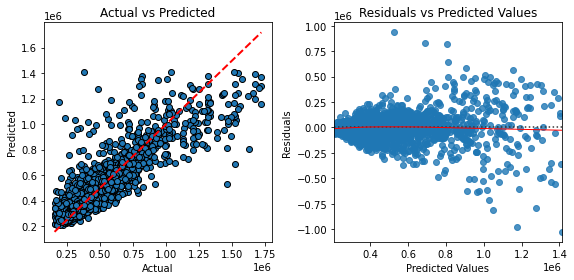

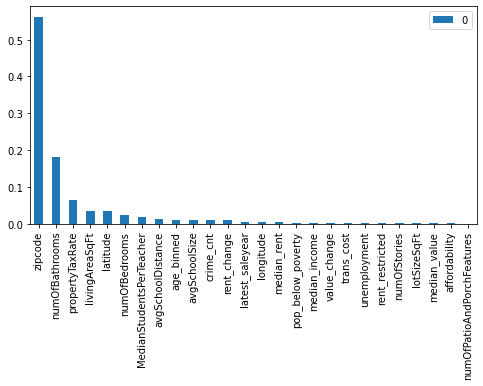

In [137]:
zipcode_cols = ['pop_below_poverty', 'median_income', 'unemployment', 'affordability', 'rent_restricted', 'median_rent', 
                'median_value', 'rent_change', 'value_change', 'trans_cost', 'crime_cnt']
eval_features(baseline_rf, revised_features+zipcode_cols)

In [466]:
# we'll try a baseline model of Linear Regression to compare feature importance
lr_model = make_pipeline(preprocessors_lr, LinearRegression())

scores = cross_validate(lr_model, X_train, y_train, n_jobs=-1, scoring=scoring, cv=kfold_cv)
print(f"Avergae R2 score: {scores['test_r2'].mean():.3f} +/- {scores['test_r2'].std():.3f}")
print(f"RMSE score: {-scores['test_neg_root_mean_squared_error'].mean():,.3f}")

Avergae R2 score: 0.728 +/- 0.014
RMSE score: 161,468.200


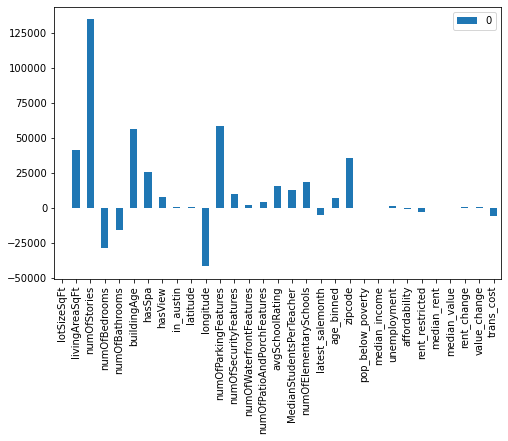

In [471]:
lr_model.fit(X_train, y_train)
pd.DataFrame(lr_model.steps[1][1].coef_, index=X_train.columns).plot(kind='bar', figsize=(8,5));

In [480]:
rf_model = make_pipeline(preprocessors, RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10))
scores = cross_validate(rf_model, X_train, y_train, n_jobs=-1, cv=kfold_cv, scoring=scoring, return_train_score=True)
print(scores['test_r2'].mean())
print(scores['train_r2'].mean())

0.8011462811612062
0.9226738687071476


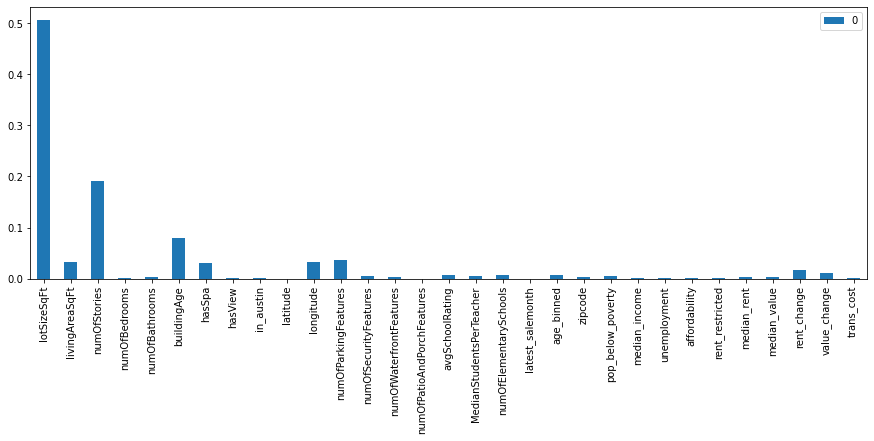

In [481]:
rf_model.fit(X_train, y_train)
pd.DataFrame(rf_model.steps[1][1].feature_importances_, index=X_train.columns).plot(kind='bar', figsize=(15,5));

#### Conclusion:
Intrestingly, the new features, in spite of having high correlation with price, do not get picked up by the model and lot size is still the most predictive feature. 
This is a bit counterintuitive as one would have imagined size of the house itself abd number of bedrooms and bathrooms to be the ones driving the price up or down. After a quick search on average lot sizes in Austin, I found out that Austin was ranked No. 3 in a report for largest lot sizes in the country and this has actually shifted homebuyer attitudes toward lot sizes and outdoor space, specially considering half of our dataset corresponds with the Covid-19 pandemic years, working from home and trends of people moving to larger houses suitable for the extended family.

"The Austin housing market has a lot to offer, including sizable lots.
Lots in Austin are the largest among big cities in the state and the third-largest among big cities in the country, according to a recent report by StorageCafe.
In Austin, the median lot size is around 8,600 square feet. That’s more than 400 square feet larger than the median lot size in Dallas, the No. 2 major city in Texas.
In Austin, land is a significant factor in determining a home's value. Homes on larger lots can demand higher sales prices, often regardless of the home's size. In 2021, unprecedented housing demand is pushing prices to record highs — but what buyers and builders doing with the space?
The StorageCafe report shows that, on average, a home in Austin takes up just over 20% of the lot, leaving the rest for outdoor living, but that is for all lots, not just those on the market. Some agents say new buyers may have a hard time getting their hands on these larger lots.
Nationwide, yards are getting harder to come by, according to the report. Lot sizes are generally falling while home sizes are rising, leaving less space for outdoor living.
“Across the country, if you do want a yard, you really have to pay a premium,” said Isaac Hiatt, a product specialist with real estate data company Yardi Matrix."

ref:
https://www.reddit.com/r/Austin/comments/ope9ju/how_homebuyer_attitudes_toward_lot_sizes_outdoor/

#### Can I introduce a feature to identify luxury properties?

In [219]:
luxury = df[df['price']>=1000000][revised_features]
non_luxury = df[df['price']<1000000][revised_features]
print('luxury ', luxury.shape[0], ' vs. non_luxury ', non_luxury.shape[0])

luxury  716  vs. non_luxury  12935


In [220]:
luxury.describe()

latest_saleyear  latitude  longitude   zipcode  \
count           716.00    716.00     716.00    716.00   
mean          2,019.14     30.30     -97.80 78,724.91   
std               0.84      0.05       0.06     18.36   
min           2,018.00     30.13     -98.02 78,619.00   
25%           2,018.00     30.26     -97.84 78,704.00   
50%           2,019.00     30.30     -97.78 78,731.00   
75%           2,020.00     30.34     -97.76 78,735.00   
max           2,021.00     30.50     -97.69 78,759.00   

       numOfPatioAndPorchFeatures  parkingSpaces  numOfBedrooms  \
count                      716.00         716.00         716.00   
mean                         0.85           1.99           4.09   
std                          1.20           1.26           0.80   
min                          0.00           0.00           1.00   
25%                          0.00           1.00           4.00   
50%                          0.00           2.00           4.00   
75%                          2.00           3.00           5.00   
max                          8.00           6.00           7.00   

       numOfBathrooms  lotSizeSqFt  livingAreaSqFt  numOfStories  age_binned  \
count          716.00       716.00          716.00        716.00      716.00   
mean             4.02    20,853.41        3,563.49          1.78        3.06   
std              1.11    17,589.56        1,096.67          0.52        1.34   
min              1.00     3,149.00          590.00          1.00        1.00   
25%              3.00     7,840.00        2,728.50          1.00        2.00   
50%              4.00    13,503.60        3,418.50          2.00        3.00   
75%              5.00    27,007.20        4,286.25          2.00        4.00   
max              8.00    61,628.00        8,880.00          3.00        5.00   

       avgSchoolRating  MedianStudentsPerTeacher  
count           716.00                    716.00  
mean              6.83                     15.44  
std               1.37                      1.25  
min               3.00                     10.00  
25%               6.00                     15.00  
50%               7.00                     16.00  
75%               7.00                     16.00  
max              10.00                     18.00

In [221]:
def is_luxury(row):
    num_br = row['numOfBedrooms']
    num_bath = row['numOfBathrooms']
    floor_area = row['livingAreaSqFt']
    lot_area = row['lotSizeSqFt']
    
    if num_br>=4 and num_bath >=3 and floor_area > 2500 and lot_area > 7800:
        return 1
    else:
        return 0

In [222]:
luxury['is_luxury'] = luxury.apply(is_luxury, axis=1)
non_luxury['is_luxury'] = non_luxury.apply(is_luxury, axis=1)

In [223]:
luxury['is_luxury'].value_counts(normalize=True)

1   0.61
0   0.39
Name: is_luxury, dtype: float64

In [224]:
non_luxury['is_luxury'].value_counts(normalize=True)

0   0.81
1   0.19
Name: is_luxury, dtype: float64

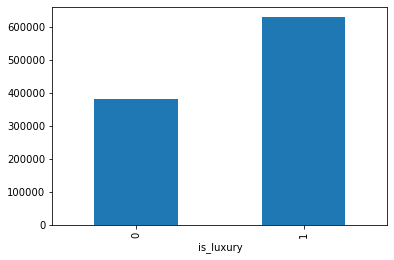

In [228]:
df['is_luxury'] = df.apply(is_luxury, axis=1)
df.groupby('is_luxury')['price'].median().plot(kind='bar');

   test_R2  test_R2_std  test_RMSE  train_R2  train_RMSE
0     0.80         0.01 116,476.25      0.90   81,186.90


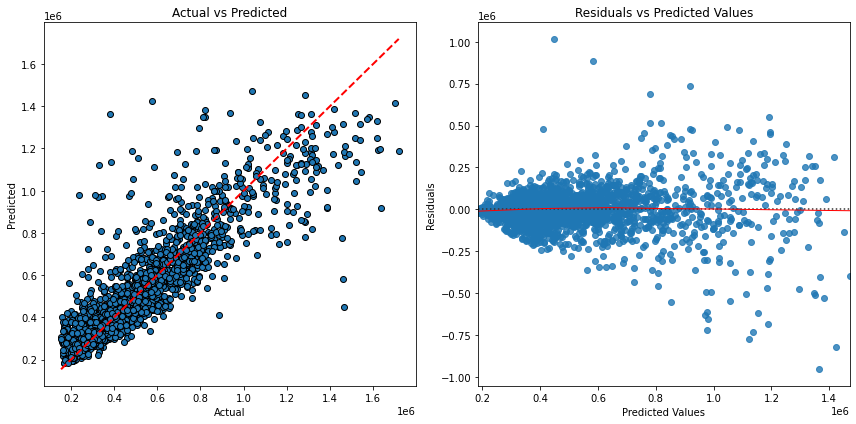

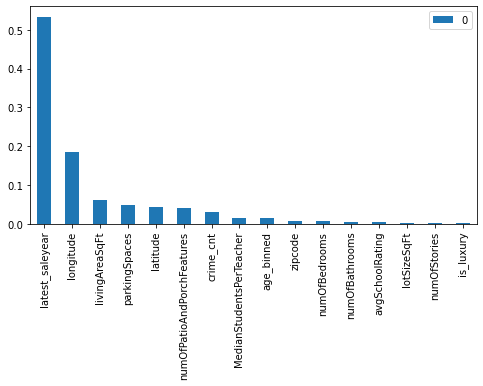

In [225]:
X_train['is_luxury'] = X_train.apply(is_luxury, axis=1)
X_test['is_luxury'] = X_test.apply(is_luxury, axis=1)

eval_features(baseline_rf, features=revised_features+['crime_cnt','is_luxury'])

In [230]:
# defining best features
best_features = revised_features + ['crime_cnt']
X_train[best_features].head(3)

latest_saleyear  latitude  longitude  zipcode  \
3200             2020     30.39     -97.69    78758   
3348             2019     30.36     -97.72    78757   
597              2018     30.44     -97.80    78750   

      numOfPatioAndPorchFeatures  parkingSpaces  numOfBedrooms  \
3200                           2              2              4   
3348                           0              1              4   
597                            0              1              3   

      numOfBathrooms  lotSizeSqFt  livingAreaSqFt  numOfStories  age_binned  \
3200            3.00     9,016.00        2,111.00             2           2   
3348            2.00     7,971.00        1,338.00             1           1   
597             3.00    17,424.00        2,550.00             1           3   

      avgSchoolRating  MedianStudentsPerTeacher  crime_cnt  
3200             4.00                        13     158183  
3348             4.00                        14      53382  
597              9.00                        16      25262

<a id="tuning" ></a>
## Model Tuning
We'll tune an XGBoost and RandomForest model and decide between the two at the end.

#### XGBoost

In [232]:
model_xgb = Pipeline([
    ('pre', preprocessors),
    ('reg', XGBRegressor(random_state=42, tree_method='hist'))
])

params = {
    'pre__te__smoothing': [1, 5, 10, 20, 40],
    'pre__te__min_samples_leaf': [1, 5, 10],
    'reg__n_estimators': [100, 200, 300],
    'reg__max_depth': np.arange(4,9),
    'reg__learning_rate': [0.05, 0.1, 0.2],
    'reg__gamma': [0.1, 0.3, 0.5],
    'reg__min_child_weight': [10, 15, 20],
    'reg__subsample':[0.7, 0.8, 0.9]    
}

gs_xgb = RandomizedSearchCV(model_xgb, params, n_iter=50, scoring=scoring, n_jobs=-1, refit='r2', cv=kfold_cv, random_state=42,
                           return_train_score=True)

gs_xgb.fit(X_train[best_features], y_train)
print("Best index:", gs_xgb.best_index_)
print("Best parameters:", gs_xgb.best_params_)

Best index: 43
Best parameters: {'reg__subsample': 0.7, 'reg__n_estimators': 100, 'reg__min_child_weight': 20, 'reg__max_depth': 8, 'reg__learning_rate': 0.05, 'reg__gamma': 0.5, 'pre__te__smoothing': 5, 'pre__te__min_samples_leaf': 5}


In [233]:
def gs_result(gs):
    ind = gs.best_index_
    print(f"test r2 = {gs.cv_results_['mean_test_r2'][ind].round(3)}")
    print(f"test rmse = {-gs.cv_results_['mean_test_neg_root_mean_squared_error'][ind].round(3)}")
    print(f"train r2 = {gs.cv_results_['mean_train_r2'][ind].round(3)}")
    print(f"train rmse = {-gs.cv_results_['mean_train_neg_root_mean_squared_error'][ind].round(3)}")

In [234]:
gs_result(gs_xgb)

test r2 = 0.807
test rmse = 113529.653
train r2 = 0.879
train rmse = 89990.692


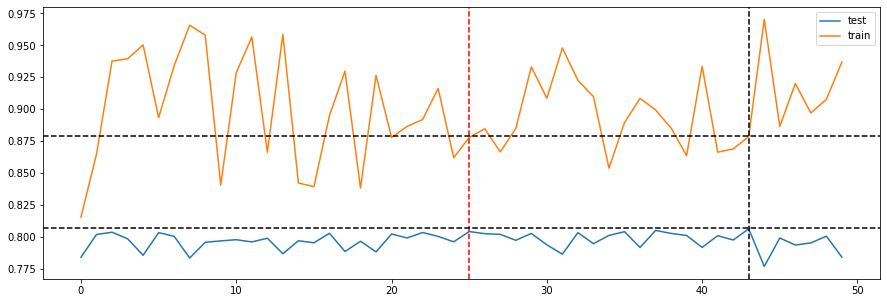

In [235]:
gs_df = pd.DataFrame({'test':list(gs_xgb.cv_results_['mean_test_r2']),
                       'train':list(gs_xgb.cv_results_['mean_train_r2'])})

# visualizing results of RandomizedGridSearchCV to see how we can improve params and if there is a better candidate on train/test ratio
gs_df.plot(kind='line', figsize=(15,5))
plt.axvline(x=43, color='black', linestyle='--')
plt.axvline(x=25, color='red', linestyle='--')
plt.axhline(y=0.807, color='black', linestyle='--')
plt.axhline(y=0.879, color='black', linestyle='--')
plt.show();

In [481]:
gs_xgb.best_params_

{'reg__subsample': 0.7,
 'reg__n_estimators': 100,
 'reg__min_child_weight': 20,
 'reg__max_depth': 8,
 'reg__learning_rate': 0.05,
 'reg__gamma': 0.5,
 'pre__te__smoothing': 5,
 'pre__te__min_samples_leaf': 5}

### running xgboost using early stopping to find optimal n_estimators

In [236]:
preprocessors = ColumnTransformer([
    ('te', TargetEncoder(cols='zipcode', handle_missing='ignore', smoothing=5, min_samples_leaf=5), ['zipcode']),
    ('scaler', MinMaxScaler(), ['lotSizeSqFt', 'livingAreaSqFt'])
], remainder='passthrough')

X_train_transformed = preprocessors.fit_transform(X_train[best_features], y_train)
X_test_transformed = preprocessors.transform(X_test[best_features])

xgb = XGBRegressor(random_state=42, n_estimators=300, early_stopping_rounds=10, learning_rate=0.05, max_depth=8, gamma=0.5,
                  subsample=0.7, min_child_weight=20, tree_method='hist')

xgb.fit(X_train_transformed, y_train, 
        eval_set=[(X_train_transformed, y_train), (X_test_transformed, y_test)], verbose=10)

[0]	validation_0-rmse:526566.25868	validation_1-rmse:525256.79222
[10]	validation_0-rmse:331506.56001	validation_1-rmse:328995.87001
[20]	validation_0-rmse:219004.89038	validation_1-rmse:218727.10484
[30]	validation_0-rmse:156946.87458	validation_1-rmse:160698.25245
[40]	validation_0-rmse:124583.86833	validation_1-rmse:133673.89634
[50]	validation_0-rmse:108404.91849	validation_1-rmse:122172.79671
[60]	validation_0-rmse:100697.32797	validation_1-rmse:118219.49090
[70]	validation_0-rmse:96234.73170	validation_1-rmse:116528.48320
[80]	validation_0-rmse:93616.86189	validation_1-rmse:116035.00201
[90]	validation_0-rmse:91686.64810	validation_1-rmse:115765.66159
[100]	validation_0-rmse:90360.55349	validation_1-rmse:115597.10018
[110]	validation_0-rmse:89068.08765	validation_1-rmse:115449.14788
[120]	validation_0-rmse:88102.59092	validation_1-rmse:115419.48508
[128]	validation_0-rmse:87261.11369	validation_1-rmse:115681.99356


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [237]:
# we'll run the same model(setting optimized n_estimator) & use cross_validate to check training scores & also stablility of 
# model across different folds
xgb = XGBRegressor(random_state=42, n_estimators=120, learning_rate=0.05, max_depth=8, gamma=0.5, subsample=0.7, 
                   min_child_weight=20, tree_method='hist')

pipeline = Pipeline([
    ('preprocessor', preprocessors),
    ('regrssor', xgb)
])

scores = cross_validate(pipeline, X_train[best_features], y_train, n_jobs=-1, scoring=scoring, cv=kfold_cv, return_train_score=True)
print("Average of test R2 scores: ", scores['test_r2'].mean().round(3))
print("std of test R2 scores: ", scores['test_r2'].std().round(3))
print("Average of train R2 scores: ", scores['train_r2'].mean().round(3))

Average of test R2 scores:  0.807
std of test R2 scores:  0.014
Average of train R2 scores:  0.885


In [238]:
-scores['test_neg_root_mean_squared_error'].round(2)

array([111894.46, 113695.89, 117579.86, 117311.21, 106183.71])

In [240]:
-scores['test_r2'].round(2)

array([-0.82, -0.8 , -0.79, -0.8 , -0.83])

Final R2 score:  0.791


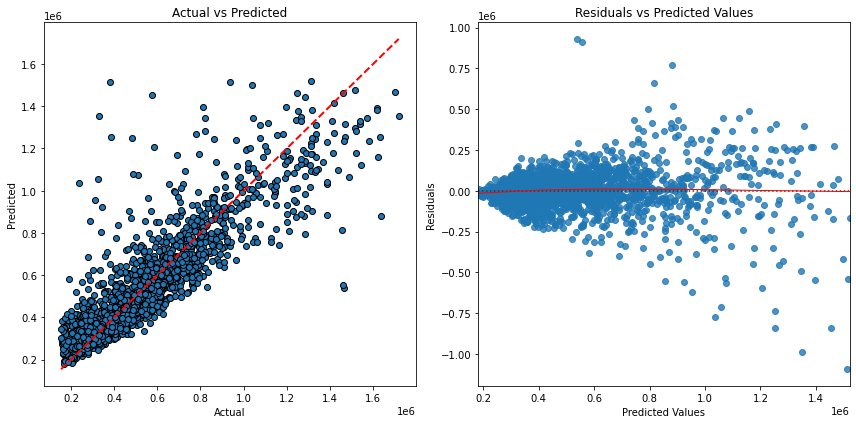

In [241]:
pipeline.fit(X_train[best_features], y_train)
y_pred_xgb = pipeline.predict(X_test[best_features])

print("Final R2 score: ", r2_score(y_test, y_pred_xgb).round(3))

# adding prediction to a dataframe to investigate predictions later
prediction_df = X_test[best_features].join(y_test)
prediction_df['pred_xgb'] = y_pred_xgb

# plot residuals
plot_residuals(y_pred_xgb)

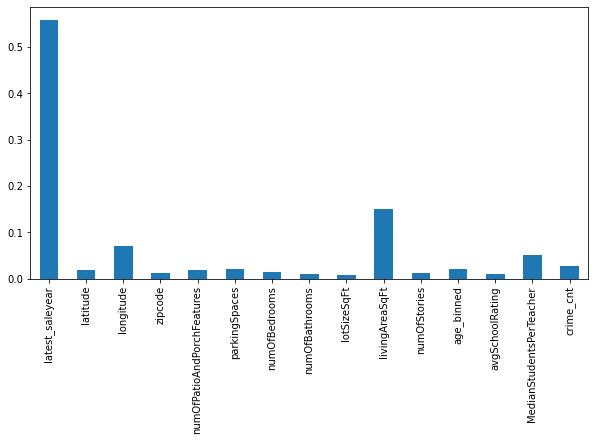

In [242]:
pd.Series(pipeline.steps[1][1].feature_importances_, index=X_train[best_features].columns).plot(kind='bar', figsize=(10,5));

#### Random Forest

In [244]:
# the GridSearchCV on Random Forest constantly picks up more complex parameters. We'd need to examin if the model truely 
# needs to be more complex or not. I tested stratified KFold to make sure the training data and validation data have a similar 
# distribution. If not, the model might be learning noise rather than the signal. 
from sklearn.model_selection import  StratifiedKFold

y_train_series = pd.Series(y_train)

# Create quantile-based bins
y_binned = pd.qcut(y_train_series, q=10, labels=False, duplicates='drop')

# Check the number of samples in each bin
bin_counts = y_binned.value_counts().sort_index()
print(bin_counts)

# Define StratifiedKFold with the created bins
strat_kfold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

0    1093
1    1092
2    1092
3    1095
4    1112
5    1068
6    1098
7    1089
8    1091
9    1090
Name: price, dtype: int64


In [246]:
# the result of both CV approaches are the same so to continue with GridSearch, we first prioritize max_depth by taking on a 
# bigger range and and then finding an optimal number of estimators. 
model_rf = Pipeline([
    ('preprocessor', preprocessors),
    ('reg', RandomForestRegressor(random_state=42, max_features='sqrt'))
])

params = {
    'reg__n_estimators': [230, 240, 250, 260, 270, 280],
    'reg__max_depth': np.arange(13, 18),
    'reg__min_samples_split': [10, 12, 14],
    'reg__min_samples_leaf': [5, 6],
    'reg__criterion': ["squared_error", "friedman_mse", "poisson"]
}

gs_rf = RandomizedSearchCV(model_rf, params, random_state=42, error_score='raise',
                           n_iter=50, scoring=scoring, refit='r2', n_jobs=-1, 
                           cv=strat_kfold_cv.split(X_train[best_features], y_binned), 
                           return_train_score=True)

gs_rf.fit(X_train[best_features], y_train)
print("Best index:", gs_rf.best_index_)
print("Best parameters:", gs_rf.best_params_)

Best index: 4
Best parameters: {'reg__n_estimators': 240, 'reg__min_samples_split': 10, 'reg__min_samples_leaf': 5, 'reg__max_depth': 16, 'reg__criterion': 'poisson'}


In [247]:
params = {
    'reg__n_estimators': [200, 210, 220, 230, 240],
    'reg__max_depth': np.arange(13, 17),
    'reg__min_samples_split': [8, 9, 10, 11, 12],
    'reg__min_samples_leaf': [6],
    'reg__criterion': ["squared_error", "friedman_mse", "poisson"]
}

gs_rf = GridSearchCV(model_rf, params, scoring=scoring, refit='r2', n_jobs=-1, return_train_score=True,
                     cv=strat_kfold_cv.split(X_train[best_features], y_binned))

gs_rf.fit(X_train[best_features], y_train)
print("Best index:", gs_rf.best_index_)
print("Best parameters:", gs_rf.best_params_)

Best index: 253
Best parameters: {'reg__criterion': 'poisson', 'reg__max_depth': 15, 'reg__min_samples_leaf': 6, 'reg__min_samples_split': 8, 'reg__n_estimators': 230}


In [248]:
gs_result(gs=gs_rf)

test r2 = 0.793
test rmse = 117421.74
train r2 = 0.858
train rmse = 97523.441


In [250]:
# is the model stable?
rf = gs_rf.best_estimator_

scores = cross_validate(rf, X_train[best_features], y_train, n_jobs=-1, scoring=scoring, return_train_score=True,
                       cv= strat_kfold_cv.split(X_train[best_features], y_binned))

print("Average of test R2 scores: ", scores['test_r2'].mean().round(3))
print("std of test R2 scores: ", scores['test_r2'].std().round(3))
print("Average of train R2 scores: ", scores['train_r2'].mean().round(3))

Average of test R2 scores:  0.793
std of test R2 scores:  0.008
Average of train R2 scores:  0.858


In [251]:
scores['test_r2'].round(3)

array([0.8  , 0.798, 0.777, 0.796, 0.795])

Final R2 score:  0.783


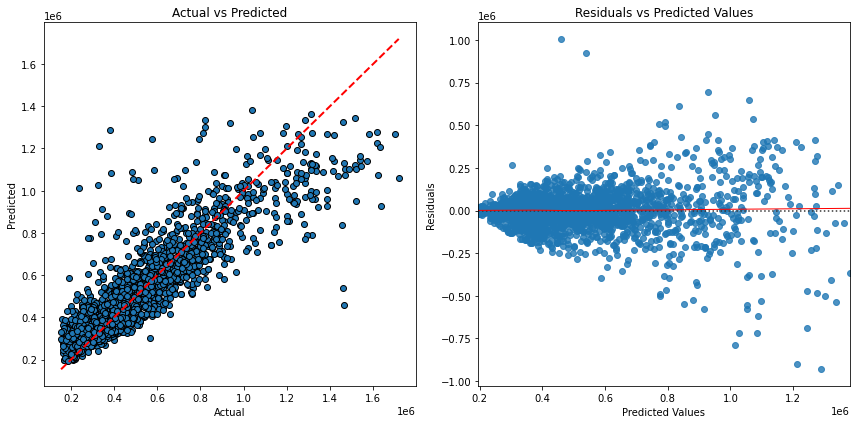

In [252]:
# Final R2 score on X_test
rf.fit(X_train[best_features], y_train)
y_pred_rf = rf.predict(X_test[best_features])

print("Final R2 score: ", r2_score(y_test, y_pred_rf).round(3))

# adding to prediction_df
prediction_df['pred_rf'] = y_pred_rf

plot_residuals(y_pred_rf)

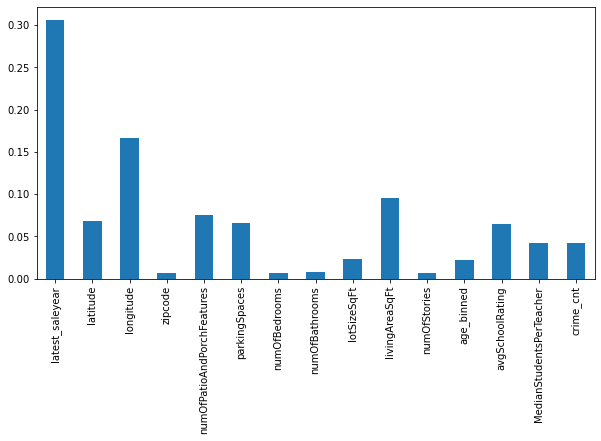

In [705]:
pd.Series(rf.steps[1][1].feature_importances_, index=X_train[best_features].columns).plot(kind='bar', figsize=(10,5));

In [255]:
import joblib

# save the model to disk
joblib.dump(pipeline, 'xgb_model.joblib')
joblib.dump(rf, 'rf_model.joblib')
 
# load the model from disk
# loaded_model = joblib.load('')

['rf_model.joblib']

## Model Interpretation & Final Thought

The heteroscedaticity problem unfortunately still exists.
#### investigating rows with highest prediction difference, are there similarities?
- considering fsi, most numbers are within the q1 and q3 of the distribution in our dataset. For index 10544(with the biggest difference)lot size and living area are equal, row should be removed in data cleaning. We should investigate all high fsi.
- The greatest predictied errors are model overvaluing properites below $1 mil, above $1mil, it is more underestimating.
- A feature for very big lots may also be useful.
- It can be considered that lot size moves the price in certain zipcode, like suburbs so an interaction feature between those may be beneficial.

In [256]:
prediction_df['residual'] = prediction_df['price'] - prediction_df['pred_xgb']
prediction_df['error'] = (prediction_df['price'] - prediction_df['pred_xgb']) / prediction_df['price']

In [295]:
abs(prediction_df['error']).quantile(0.32)

0.05028097018579806

In [257]:
abs(prediction_df['error']).describe()

count   2,731.00
mean        0.15
std         0.22
min         0.00
25%         0.04
50%         0.09
75%         0.17
max         3.35
Name: error, dtype: float64

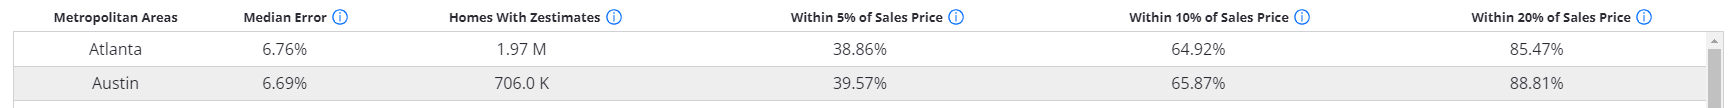

In [721]:
# Zillow's zestimate
# For off-market homes, national median error rate is 7.74%.
from IPython.display import Image, display

display(Image(filename='Zestimate_Austin.png'))

The same numbers for us are:
Median Error: 8.59%
Within 5% of Sales Price: 32%
Within 10% of Sales Price: 57%
Within 20% of Sales Price: 81%

In [268]:
prediction_df.head()

latest_saleyear  latitude  longitude  zipcode  \
12203             2020     30.19     -97.83    78748   
13138             2018     30.29     -97.77    78703   
5441              2020     30.23     -97.78    78704   
4396              2018     30.19     -97.99    78737   
8795              2019     30.42     -97.73    78727   

       numOfPatioAndPorchFeatures  parkingSpaces  numOfBedrooms  \
12203                           2              2              3   
13138                           0              1              3   
5441                            2              2              3   
4396                            0              3              4   
8795                            0              1              3   

       numOfBathrooms  lotSizeSqFt  livingAreaSqFt  numOfStories  age_binned  \
12203            2.00     6,229.00        1,396.00             1           2   
13138            2.00     8,102.00        2,142.00             1           1   
5441             3.00     7,840.00        1,398.00             1           5   
4396             4.00    16,552.80        3,497.00             1           4   
8795             3.00     9,496.00        2,169.00             1           2   

       avgSchoolRating  MedianStudentsPerTeacher  crime_cnt      price  \
12203             6.00                        16      69225 319,410.00   
13138             7.00                        16      34085 344,900.82   
5441              4.00                        12     148857 618,438.60   
4396              6.00                        16        323 657,401.86   
8795              7.00                        15      35358 420,750.95   

        pred_xgb    pred_rf    residual  error  
12203 319,706.97 329,751.21     -296.97  -0.00  
13138 925,116.81 914,336.17 -580,215.99  -1.68  
5441  612,331.69 643,186.04    6,106.91   0.01  
4396  568,937.50 587,140.69   88,464.36   0.13  
8795  439,429.66 452,283.63  -18,678.71  -0.04

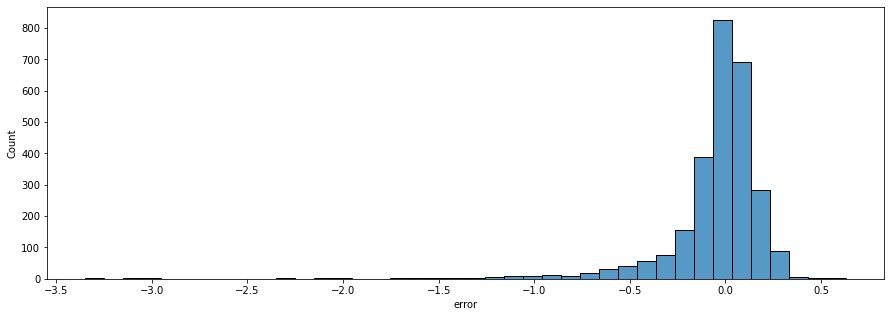

In [269]:
plt.figure(figsize=(15,5))
sns.histplot(prediction_df['error'], bins=40);

In [297]:
# The greatest difference in predictied price is model over-valuing properties that were sold for less than 500k
# checked all the rows below and all original prices are very off considering sales records shown currently on Zillow website
# predicted price is actually not very off
prediction_df[abs(prediction_df['error'])>=1.5].sort_values(by='error')

latest_saleyear  latitude  longitude  zipcode  \
15036             2020     30.33     -97.75    78731   
1992              2018     30.28     -97.88    78735   
14417             2020     30.30     -97.76    78703   
15031             2020     30.32     -97.75    78731   
9488              2020     30.25     -97.75    78704   
14863             2018     30.34     -97.75    78757   
10116             2018     30.25     -97.71    78702   
7874              2020     30.35     -97.73    78757   
13138             2018     30.29     -97.77    78703   
10557             2020     30.23     -97.76    78704   
9437              2018     30.25     -97.74    78704   

       numOfPatioAndPorchFeatures  parkingSpaces  numOfBedrooms  \
15036                           1              2              4   
1992                            0              1              5   
14417                           1              2              4   
15031                           3              2              4   
9488                            2              3              4   
14863                           0              2              4   
10116                           0              1              3   
7874                            0              1              3   
13138                           0              1              3   
10557                           4              2              4   
9437                            0              1              4   

       numOfBathrooms  lotSizeSqFt  livingAreaSqFt  numOfStories  age_binned  \
15036            3.00     8,015.00        2,891.00             2           4   
1992             6.00    61,628.00        5,828.00             1           4   
14417            4.00     8,145.00        3,560.00             1           5   
15031            4.00     8,407.00        2,715.00             2           4   
9488             3.00     7,013.00        2,575.00             1           4   
14863            3.00     8,712.00        3,105.00             2           5   
10116            3.00     7,187.00        1,730.00             2           5   
7874             3.00     8,581.00        2,830.00             1           1   
13138            2.00     8,102.00        2,142.00             1           1   
10557            3.00     7,143.00        2,828.00             2           5   
9437             5.00     8,668.00        3,400.00             2           5   

       avgSchoolRating  MedianStudentsPerTeacher  crime_cnt      price  \
15036             7.00                        16      29616 238,290.00   
1992              6.00                        16      15810 329,223.51   
14417             7.00                        16      34085 380,250.00   
15031             7.00                        16      29616 323,973.00   
9488              4.00                        14     148857 384,760.27   
14863             7.00                        16      53382 312,501.04   
10116             4.00                        10     130751 193,353.49   
7874              7.00                        16      53382 288,990.00   
13138             7.00                        16      34085 344,900.82   
10557             4.00                        12     148857 481,650.00   
9437              4.00                        14     148857 573,789.54   

          pred_xgb      pred_rf      residual  error  
15036 1,036,026.75 1,013,820.97   -797,736.75  -3.35  
1992  1,351,513.62 1,210,979.46 -1,022,290.11  -3.11  
14417 1,513,696.00 1,289,603.81 -1,133,446.00  -2.98  
15031 1,056,496.00 1,026,561.37   -732,523.00  -2.26  
9488  1,253,262.75 1,085,347.05   -868,502.48  -2.26  
14863   954,465.00   852,393.11   -641,963.96  -2.05  
10116   580,160.38   587,582.21   -386,806.89  -2.00  
7874    856,886.75   775,171.89   -567,896.75  -1.97  
13138   925,116.81   914,336.17   -580,215.99  -1.68  
10557 1,250,722.75 1,086,882.74   -769,072.75  -1.60  
9437  1,455,177.88 1,244,025.92   -881,388.33  -1.54

index 15036 was pending sales for $1.1 in 2020 which is close to predicted price.
index 1992(4017 Verano Dr), price could not have been $329,223.51, Zillow says on July 2018 it was pending sales for $3.5mil.
index 14417(1802 Mohle Dr) shows price $380,250 but current Zillow estimate is $2.5 mil.
index 15031(2903 Village Dr): Zillow show $1.2mil was the pending sales price on March 2020 so 323,973 is definitely wronge.
index 14863(3102 Hunt Trl) is probably wrong as well. Zillow hides the sold price but shows that it was listed for $1.1mil, not $299,000.
index 7874(7505 Daugherty St) may have wronge price input given tax assessment in the year it was sold is around $579000
index 9488(1707 Eva St) was pending sales for $1.56mil in 2020 which is very close to predicted price by XGBoost model.
index 10116 was pending sales for 700k in 2023, which is closer to predicted price than price shown on the dataset, $193k
index 10557 was actually sold in 2020 for $1.32mil, much closer to predicted price of $1.25 than price shown $481k

I can not pick out all the wronge inputs but how does our error change if I were to just exclude these records?

In [311]:
abs(prediction_df[abs(prediction_df['error'])<1.5]['error']).describe()

count   2,720.00
mean        0.14
std         0.18
min         0.00
25%         0.04
50%         0.09
75%         0.17
max         1.45
Name: error, dtype: float64

In [282]:
# properties sold for more than $1mil: where are the predictions most off?
# These prices seem correct considering records shown on Zillow
prediction_df[(prediction_df['price']>1000000) & (abs(prediction_df['error'])>=0.5)].sort_values(by='error', ascending=False)

latest_saleyear  latitude  longitude  zipcode  \
5726             2018     30.14     -97.77    78747   
9298             2019     30.25     -97.73    78702   

      numOfPatioAndPorchFeatures  parkingSpaces  numOfBedrooms  \
5726                           0              5              3   
9298                           0              1              3   

      numOfBathrooms  lotSizeSqFt  livingAreaSqFt  numOfStories  age_binned  \
5726            3.00    61,628.00        3,755.00             1           1   
9298            2.00     6,969.00        1,308.00             1           1   

      avgSchoolRating  MedianStudentsPerTeacher  crime_cnt        price  \
5726             5.00                        15      13765 1,463,215.59   
9298             4.00                        11     130751 1,462,722.89   

       pred_xgb    pred_rf   residual  error  
5726 537,412.50 460,971.48 925,803.09   0.63  
9298 555,696.81 540,343.28 907,026.08   0.62

In [281]:
df.loc[2460]

city                                                                     austin
streetAddress                                               9215 Silver Pine Cv
zipcode                                                                   78733
description                   Beautiful 4/5 bedroom home on a quiet street i...
latitude                                                                  30.31
longitude                                                                -97.87
propertyTaxRate                                                            1.98
hasAssociation                                                                1
hasCooling                                                                    1
hasGarage                                                                     1
hasHeating                                                                    1
hasSpa                                                                        0
hasView                                 

In [848]:
# some of the listings the model got right
prediction_df[abs(prediction_df['error'])<0.05].sort_values(by='error', ascending=False).head()

latest_saleyear  latitude  longitude  zipcode  \
5116              2020     30.19     -97.82    78745   
6427              2020     30.19     -97.84    78748   
14670             2020     30.33     -97.76    78731   
14274             2018     30.30     -97.76    78703   
1283              2018     30.16     -97.64    78617   

       numOfPatioAndPorchFeatures  parkingSpaces  numOfBedrooms  \
5116                            0              2              4   
6427                            3              4              4   
14670                           5              2              3   
14274                           0              1              3   
1283                            0              2              3   

       numOfBathrooms  lotSizeSqFt  livingAreaSqFt  numOfStories  age_binned  \
5116             2.00    10,280.00        1,610.00             1           2   
6427             3.00     6,969.00        2,578.00             2           3   
14670            3.00    14,374.80        2,223.00             1           1   
14274            3.00     9,104.00        2,150.00             1           1   
1283             2.00     4,965.00        1,346.00             1           4   

       avgSchoolRating  MedianStudentsPerTeacher  crime_cnt        price  \
5116              4.00                        13     144330   404,586.00   
6427              7.00                        16      69225   430,950.00   
14670             7.00                        16      29616 1,064,700.00   
14274             7.00                        16      34085   939,593.44   
1283              3.00                        14      17522   203,805.03   

          pred_xgb    pred_rf  residual  error  
5116    384,357.88 380,568.82 20,228.12   0.05  
6427    409,509.84 424,400.04 21,440.16   0.05  
14670 1,012,009.00 952,438.22 52,691.00   0.05  
14274   893,281.88 911,870.01 46,311.56   0.05  
1283    193,775.08 200,702.63 10,029.95   0.05

In [849]:
df.loc[5116]

city                                                                     austin
streetAddress                                               2307 Stone River Dr
zipcode                                                                   78745
description                   This is a gorgeous home in a prime quiet locat...
latitude                                                                  30.19
longitude                                                                -97.82
propertyTaxRate                                                            1.98
hasAssociation                                                                0
hasCooling                                                                    1
hasGarage                                                                     1
hasHeating                                                                    1
hasSpa                                                                        0
hasView                                 

### A final test: How accurate can the model predict a listing from mid 2021?

In [287]:
df[df['zipcode']==78748].MedianStudentsPerTeacher.mean()

15.074817518248175

In [284]:
X_test[best_features].head()

latest_saleyear  latitude  longitude  zipcode  \
12203             2020     30.19     -97.83    78748   
13138             2018     30.29     -97.77    78703   
5441              2020     30.23     -97.78    78704   
4396              2018     30.19     -97.99    78737   
8795              2019     30.42     -97.73    78727   

       numOfPatioAndPorchFeatures  parkingSpaces  numOfBedrooms  \
12203                           2              2              3   
13138                           0              1              3   
5441                            2              2              3   
4396                            0              3              4   
8795                            0              1              3   

       numOfBathrooms  lotSizeSqFt  livingAreaSqFt  numOfStories  age_binned  \
12203            2.00     6,229.00        1,396.00             1           2   
13138            2.00     8,102.00        2,142.00             1           1   
5441             3.00     7,840.00        1,398.00             1           5   
4396             4.00    16,552.80        3,497.00             1           4   
8795             3.00     9,496.00        2,169.00             1           2   

       avgSchoolRating  MedianStudentsPerTeacher  crime_cnt  
12203             6.00                        16      69225  
13138             7.00                        16      34085  
5441              4.00                        12     148857  
4396              6.00                        16        323  
8795              7.00                        15      35358

In [290]:
test = [[2021, 30.18, -97.80, 78748, 2, 4, 2, 2, 6973, 1009, 1, 2, 5, 15, 69225]]
df_test = pd.DataFrame(test, columns=X_test[best_features].columns)
df_test

latest_saleyear  latitude  longitude  zipcode  numOfPatioAndPorchFeatures  \
0             2021     30.18     -97.80    78748                           2   

   parkingSpaces  numOfBedrooms  numOfBathrooms  lotSizeSqFt  livingAreaSqFt  \
0              4              2               2         6973            1009   

   numOfStories  age_binned  avgSchoolRating  MedianStudentsPerTeacher  \
0             1           2                5                        15   

   crime_cnt  
0      69225

In [293]:
# Zillow shows this house to be pending sales for $335,000(2024)
predicted_price_in_2021 = pipeline.predict(df_test)
predicted_price_in_2021

array([311340.78], dtype=float32)